In [ ]:
'''
Reference: Peltason L et al.,
Rationalizing three-dimensional activity landscapes and the influence of molecular representations on landscape topology and formation of activity cliffs.,
J Chem Inf Model 50, 1021-1033, 2010.
'''

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
import pybel

In [6]:
def scale(X, center=True, scale=True):
    ''' compatible with GNU R scale() '''
    if center:
        X -= X.mean(axis=0)

    if scale:
        std = X.std(axis=0)
        # assign 1. if std is False
        std = np.where(std, std, 1.)
        X /= std
    return X

In [7]:
def pca(X, npc=2):
    # calculate eigenvalues(l) and eigenvectors(w) of the covariance matrix
    C = np.cov(X.T)
    l,w = np.linalg.eig(C)

    # sort eigenvectors by eigenvalue in descending order
    w = w[:,np.argsort(l)[::-1]]
    ''' T = X*W '''
    pc = np.dot(X, w[:,:npc])
    return pc

In [8]:
def fp_mds(fptype):
    fps = []
    solubility = []
    for mol in pybel.readfile(filename='solubility.test.sdf', format='sdf'):
        fp = mol.calcfp(fptype=fptype).bits
        fps.append(fp)
        solubility.append(np.float32(mol.data['SOL']))

    ncol = max(max(fp) if len(fp) > 0 else 0 for fp in fps)
    mat = np.zeros((len(fps), ncol+1), dtype=np.float32)
    for i,fp in enumerate(fps):
        mat[i,fp] = 1.

    mat = scale(mat)
    pcs = np.real(pca(mat, npc=2))

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(pcs[:,0].min(), pcs[:,0].max()), np.linspace(pcs[:,1].min(), pcs[:,1].max())
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(pcs[:,0], pcs[:,1], solubility, function='linear', smooth=0.1)
    zi = rbf(xi, yi)

    plt.subplot(2, 3, pybel.fps[-6:].index(fptype)+1)
    plt.title('%s' % fptype)
    plt.imshow(zi, vmin=zi.min(), vmax=zi.max(), origin='lower', cmap='RdYlGn_r', aspect='auto',
            extent=[pcs[:,0].min(), pcs[:,0].max(), pcs[:,1].min(), pcs[:,1].max()])
    plt.scatter(pcs[:,0], pcs[:,1], c=solubility, cmap='RdYlGn_r')

In [12]:
def main():
    plt.figure(figsize=(9,6))
    for fptype in pybel.fps[-6:]:
        print(fptype)
        fp_mds(fptype)
    plt.tight_layout()
    plt.show()

ecfp6
ecfp8
fp2
fp3
fp4
maccs


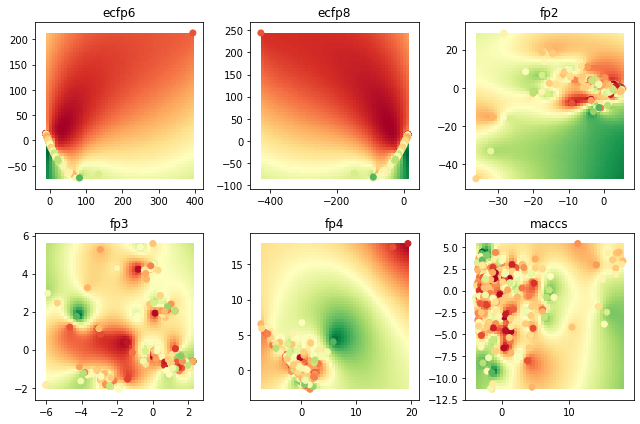

In [13]:
if __name__ == '__main__':
    main()